In [1]:
%store -r

In [3]:
import os
import pathlib
from glob import glob
import requests

from math import floor, ceil

import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import xarray as xr
import xrspatial

c:\Users\tjsto\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Elevation Data
Elevation from the SRTM (available from the earthaccess API)

In [4]:
earthaccess.login()

In [5]:
# Search earthaccess for a suitable dataset
datasets = earthaccess.search_datasets(keyword='SRTMGL1')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])


SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL1N NASA Shuttle Radar Topography Mission Global 1 arc second number V003
SRTMGL1_NUMNC NASA Shuttle Radar Topography Mission Global 1 arc second Number NetCDF V003
SRTMGL3S NASA Shuttle Radar Topography Mission Global 3 arc second sub-sampled V003


In [ ]:
# def srtm_data_download():
    

In [6]:
elevation_dir = os.path.join(data_dir, 'srtm')

os.makedirs(elevation_dir, exist_ok=True)

In [8]:
def set_buffer(boundary_gdf, buffer=0):
    """
    Increases the max bounds of a geo data frame by a set amount.
    Returns the max bounds as a tuple.
    """
    bounds = tuple(boundary_gdf.total_bounds)
    xmin, ymin, xmax, ymax = bounds
    bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

    return bounds_buffer

In [9]:
srtm_pattern = os.path.join(elevation_dir, '*.hgt.zip')

bounds_buffer = set_buffer(GWNF_gdf, 0.025)

if not glob(srtm_pattern):    
    
    srtm_results = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=bounds_buffer
    )
    srtm_results = earthaccess.download(srtm_results, elevation_dir)

In [10]:
srtm_da_list = []

for srtm_path in glob(srtm_pattern):
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    cropped_da = tile_da.rio.clip_box(*bounds_buffer)
    srtm_da_list.append(cropped_da)


srtm_da = rxrmerge.merge_arrays(srtm_da_list)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

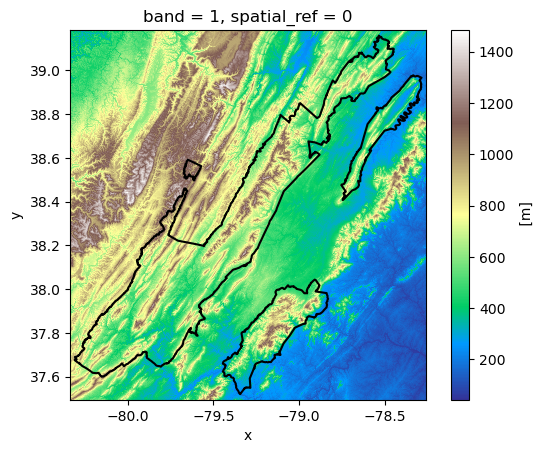

In [11]:
srtm_da.plot(cmap='terrain')
GWNF_gdf.boundary.plot(ax=plt.gca(), color='black')

Calculate at least one derived topographic variable (slope or aspect) to use in your model. You probably will wish to use the xarray-spatial library, which is available in the latest earth-analytics-python environment (but will need to be installed/updated if you are working on your own machine). Note that calculated slope may not be correct if you are using a CRS with units of degrees; you should re-project into a projected coordinate system with units of meters, such as the appropriate UTM Zone.

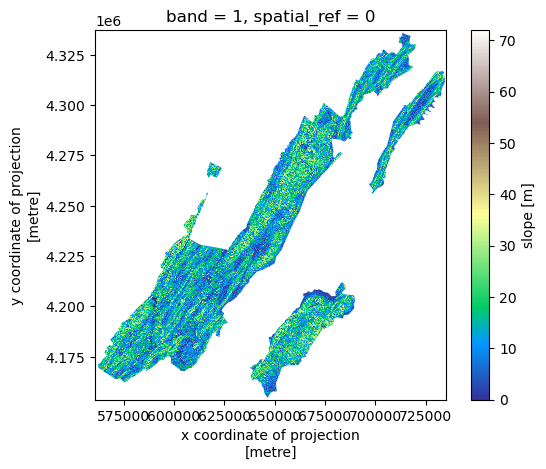

In [12]:
# Reproject so units are in meters
epsg_utm17n = 32617
srtm_proj_da = srtm_da.rio.reproject(epsg_utm17n)
GWNF_proj_gdf = GWNF_gdf.to_crs(epsg_utm17n)
bounds_proj = tuple(GWNF_proj_gdf.total_bounds)

# Calculate rsxspatial.slope or .aspect
slope_full_da = xrspatial.slope(srtm_proj_da)
#slope_da = slope_full_da.rio.clip_box(*bounds_proj)
slope_da = slope_full_da.rio.clip(GWNF_proj_gdf.geometry)

# Plot slope
slope_da.plot(cmap='terrain')
GWNF_proj_gdf.boundary.plot(ax=plt.gca(), color='white')
plt.show()